In [ ]:
import os
import pandas as pd

## Import Data

In [ ]:
folder_path = "../data/AdVitam/Preprocessed"  # This path is relative to the notebook location
database_path = os.path.join(folder_path, 'Questionnaire/Exp4_Database.csv')
pvt_path = os.path.join(folder_path, "PVT/data_PVT_exp4_scenario_type.csv")
physio_path = os.path.join(folder_path, "Physio/periods/features_segm_5.csv")
driving_path = os.path.join(folder_path, "Driving/features_tor_10s_30s_rows.csv")

database_df = pd.read_csv(database_path)
pvt_df = pd.read_csv(pvt_path)
physio_df = pd.read_csv(physio_path)
driving_df = pd.read_csv(driving_path)

### Handle Target Data

In [ ]:
database_df.head()

# 1: rural first, 2: urban first
database_rural_1 = database_df[database_df['order_scenario'] == 1][['participant_code', 'KSS_B_1', 'KSS_1']]
database_rural_1 = database_rural_1.rename(columns={'KSS_B_1': 'KSS_B', 'KSS_1': 'KSS'})
database_rural_1['first_scenario'] = 'Rural'
database_rural_1['period'] = 'Rural'

database_rural_2 = database_df[database_df['order_scenario'] == 1][['participant_code', 'KSS_B_2', 'KSS_2']]
database_rural_2 = database_rural_2.rename(columns={'KSS_B_2': 'KSS_B', 'KSS_2': 'KSS'})
database_rural_2['first_scenario'] = 'Rural'
database_rural_2['period'] = 'Urban'

database_urban_1 = database_df[database_df['order_scenario'] == 2][['participant_code', 'KSS_B_1', 'KSS_1']]
database_urban_1 = database_urban_1.rename(columns={'KSS_B_1': 'KSS_B', 'KSS_1': 'KSS'})
database_urban_1['first_scenario'] = 'Urban'
database_urban_1['period'] = 'Urban'

database_urban_2 = database_df[database_df['order_scenario'] == 2][['participant_code', 'KSS_B_2', 'KSS_2']]
database_urban_2 = database_urban_2.rename(columns={'KSS_B_2': 'KSS_B', 'KSS_2': 'KSS'})
database_urban_2['first_scenario'] = 'Urban'
database_urban_2['period'] = 'Rural'

kss_df = pd.concat([database_rural_1, database_rural_2, database_urban_1, database_urban_2])
kss_df = kss_df[['participant_code', 'first_scenario', 'period', 'KSS_B', 'KSS']]
kss_df = kss_df.rename(columns={'KSS_B': 'KSS_0', 'KSS': 'KSS_4'})
kss_df.head()

,participant_code,first_scenario,period,KSS_0,KSS_4
0,01_AC16,Rural,Rural,4,3
2,03_AC16,Rural,Rural,3,3
3,04_DC16,Rural,Rural,7,6
4,05_AC10,Rural,Rural,3,6
7,08_AC10,Rural,Rural,6,3


In [ ]:
for i in [1,2,3]:
    kss_df[f'KSS_{i}'] = (kss_df['KSS_4'] - kss_df['KSS_0']) / 4 * i + kss_df['KSS_0']
kss_df = kss_df[['participant_code', 'first_scenario', 'period', 'KSS_0', 'KSS_1', 'KSS_2', 'KSS_3', 'KSS_4']]
kss_df.head()

,participant_code,first_scenario,period,KSS_0,KSS_1,KSS_2,KSS_3,KSS_4
0,01_AC16,Rural,Rural,4,3.75,3.5,3.25,3
2,03_AC16,Rural,Rural,3,3.00,3.0,3.00,3
3,04_DC16,Rural,Rural,7,6.75,6.5,6.25,6
4,05_AC10,Rural,Rural,3,3.75,4.5,5.25,6
7,08_AC10,Rural,Rural,6,5.25,4.5,3.75,3


In [ ]:
kss_melted_df = kss_df.melt(
    id_vars=['participant_code','first_scenario','period'],
    value_vars=[f'KSS_{i}' for i in range(5)],
    var_name='segment',
    value_name='kss'
)

kss_melted_df['segment'] = kss_melted_df['segment'].str.replace('KSS_','').astype(int)

kss_melted_df = kss_melted_df.sort_values(['participant_code','period','segment']).reset_index(drop=True)

kss_melted_df['subject_id'] = kss_melted_df['participant_code'].str.extract('(\d+)').astype(int)
kss_melted_df = kss_melted_df[['subject_id', 'first_scenario', 'period', 'segment', 'kss']]

kss_raw_df = kss_df.copy()
kss_df = kss_melted_df.copy()

kss_df.head()

,subject_id,first_scenario,period,segment,kss
0,1,Rural,Rural,0,4.00
1,1,Rural,Rural,1,3.75
2,1,Rural,Rural,2,3.50
3,1,Rural,Rural,3,3.25
4,1,Rural,Rural,4,3.00


### Handle Feature Data (Pending: Add driving & database data)

In [ ]:
physio_columns = ['subject_id', 'label_first_scenario', 'period', 'segment_id'] + [col for col in physio_df.columns if col.endswith("Dr-Bl")]
physio_simplified_df = physio_df[physio_columns]
physio_simplified_df = physio_simplified_df.rename(columns={'label_first_scenario': 'first_scenario', 'segment_id': 'segment'})
physio_simplified_df.head()

,subject_id,first_scenario,period,segment,EDA_filtered_mean_Dr-Bl,EDA_filtered_min_Dr-Bl,EDA_filtered_max_Dr-Bl,EDA_filtered_std_Dr-Bl,EDA_tonic_mean_Dr-Bl,EDA_tonic_min_Dr-Bl,...,SCR_Peaks_N_Dr-Bl,SCR_Peaks_Amplitude_Mean_Dr-Bl,RSA_P2T_Mean_Dr-Bl,RSA_P2T_Mean_log_Dr-Bl,RSA_P2T_SD_Dr-Bl,RSA_P2T_NoRSA_Dr-Bl,RSA_PorgesBohrer_Dr-Bl,RSA_Gates_Mean_Dr-Bl,RSA_Gates_Mean_log_Dr-Bl,RSA_Gates_SD_Dr-Bl
0,1,Rural,Rural,0,6.240796,5.929979,6.341950,0.089752,6.241479,5.914295,...,16.0,0.157879,-0.003551,-0.116674,0.001146,0.0,0.400630,-0.231271,-0.029140,0.012048
1,1,Rural,Rural,1,4.933697,4.806328,4.407790,-0.002111,4.935073,4.812007,...,-1.0,0.012626,-0.003768,-0.124247,-0.000265,0.0,0.175800,-0.171799,-0.021565,0.015757
2,1,Rural,Rural,2,5.188408,5.132712,5.517033,0.033235,5.189599,5.139759,...,-1.0,0.254859,-0.001096,-0.034572,0.007145,0.0,0.303468,-0.171153,-0.021484,0.015238
3,1,Rural,Rural,3,4.416023,4.516889,3.809360,-0.091715,4.414348,4.516506,...,-1.0,-0.075401,-0.002492,-0.080434,0.006244,0.0,0.167533,-0.118763,-0.014858,0.017757
4,1,Rural,Rural,4,3.858262,3.911289,3.446269,-0.115461,3.859607,3.914209,...,25.0,-0.125719,-0.001319,-0.041778,0.005092,0.0,0.210252,-0.136638,-0.017114,0.015136


### Merge

In [ ]:
final_df = kss_df.merge(physio_simplified_df, on=['subject_id', 'first_scenario', 'period', 'segment'], how='left')

final_df.head()

,subject_id,first_scenario,period,segment,kss,EDA_filtered_mean_Dr-Bl,EDA_filtered_min_Dr-Bl,EDA_filtered_max_Dr-Bl,EDA_filtered_std_Dr-Bl,EDA_tonic_mean_Dr-Bl,...,SCR_Peaks_N_Dr-Bl,SCR_Peaks_Amplitude_Mean_Dr-Bl,RSA_P2T_Mean_Dr-Bl,RSA_P2T_Mean_log_Dr-Bl,RSA_P2T_SD_Dr-Bl,RSA_P2T_NoRSA_Dr-Bl,RSA_PorgesBohrer_Dr-Bl,RSA_Gates_Mean_Dr-Bl,RSA_Gates_Mean_log_Dr-Bl,RSA_Gates_SD_Dr-Bl
0,1,Rural,Rural,0,4.00,6.240796,5.929979,6.341950,0.089752,6.241479,...,16.0,0.157879,-0.003551,-0.116674,0.001146,0.0,0.400630,-0.231271,-0.029140,0.012048
1,1,Rural,Rural,1,3.75,4.933697,4.806328,4.407790,-0.002111,4.935073,...,-1.0,0.012626,-0.003768,-0.124247,-0.000265,0.0,0.175800,-0.171799,-0.021565,0.015757
2,1,Rural,Rural,2,3.50,5.188408,5.132712,5.517033,0.033235,5.189599,...,-1.0,0.254859,-0.001096,-0.034572,0.007145,0.0,0.303468,-0.171153,-0.021484,0.015238
3,1,Rural,Rural,3,3.25,4.416023,4.516889,3.809360,-0.091715,4.414348,...,-1.0,-0.075401,-0.002492,-0.080434,0.006244,0.0,0.167533,-0.118763,-0.014858,0.017757
4,1,Rural,Rural,4,3.00,3.858262,3.911289,3.446269,-0.115461,3.859607,...,25.0,-0.125719,-0.001319,-0.041778,0.005092,0.0,0.210252,-0.136638,-0.017114,0.015136


In [ ]:
final_df.shape

(630, 137)

## Data Cleaning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from scipy import stats

print("Initial shape:", final_df.shape)

# Step 1: Handle Missing Values
print("\n=== Step 1: Missing Value Processing ===")

# Remove target with missing values
print("\nRemoving rows with missing target values")
final_df = final_df[final_df['kss'].notna()]

# First, identify columns
metadata_cols = ['subject_id', 'first_scenario', 'period', 'segment', 'kss']
numeric_cols = [col for col in final_df.columns if col not in metadata_cols]

# Replace infinities with NaN
final_df = final_df.replace([np.inf, -np.inf], np.nan)

# Analyze missing values
print("\nAnalyzing missing values:")
missing_stats = pd.DataFrame({
    'Missing Values': final_df[numeric_cols].isnull().sum(),
    'Missing Percentage': (final_df[numeric_cols].isnull().sum() / len(final_df)) * 100
}).sort_values('Missing Percentage', ascending=False)

print("\nFeatures with missing values:")
print(missing_stats[missing_stats['Missing Values'] > 0].round(2))

# Handle missing values
# 1. Drop columns with too many missing values (>50%)
high_missing_threshold = 50
columns_to_drop = missing_stats[missing_stats['Missing Percentage'] > high_missing_threshold].index
if len(columns_to_drop) > 0:
    print(f"\nDropping {len(columns_to_drop)} columns with >{high_missing_threshold}% missing values:")
    print(columns_to_drop.tolist())
    final_df = final_df.drop(columns=columns_to_drop)

# 2. Drop columns with all NaN values
all_nan_cols = final_df.columns[final_df.isna().all()].tolist()
if len(all_nan_cols) > 0:
    print(f"\nDropping columns with all NaN values:")
    print(all_nan_cols)
    final_df = final_df.drop(columns=all_nan_cols)

# 3. Remove rows where all features are missing
numeric_cols = [col for col in final_df.columns if col not in metadata_cols]
completely_missing_rows = final_df[numeric_cols].isnull().all(axis=1)
rows_to_drop = completely_missing_rows.sum()
if rows_to_drop > 0:
    print(f"\nRemoving {rows_to_drop} rows with all features missing")
    final_df = final_df[~completely_missing_rows]

# 4. Fill remaining NaN values with column median
print("\nFilling remaining NaN values with column medians")
final_df[numeric_cols] = final_df[numeric_cols].fillna(final_df[numeric_cols].median())

# 5. Report final shape
print(f"\nFinal shape after cleaning: {final_df.shape}")

Initial shape: (630, 137)

=== Step 1: Missing Value Processing ===

Removing rows with missing target values

Analyzing missing values:

Features with missing values:
                          Missing Values  Missing Percentage
HRV_ULF_Dr-Bl                        630              100.00
HRV_VLF_Dr-Bl                        630              100.00
HRV_SDNNI5_Dr-Bl                     630              100.00
HRV_SDANN5_Dr-Bl                     630              100.00
RRV_HFn_Dr-Bl                        630              100.00
...                                  ...                 ...
RSA_P2T_Mean_log_Dr-Bl                31                4.92
RSA_P2T_NoRSA_Dr-Bl                   31                4.92
RSA_PorgesBohrer_Dr-Bl                31                4.92
RSA_Gates_Mean_Dr-Bl                  31                4.92
RSA_Gates_Mean_log_Dr-Bl              31                4.92

[132 rows x 2 columns]

Dropping 9 columns with >50% missing values:
['HRV_ULF_Dr-Bl', 'HRV_VLF_Dr-

In [ ]:
# Step 2: Encode Categorical Variables
print("\n=== Step 2: Categorical Encoding ===")

# Create binary encodings efficiently using a single DataFrame
categorical_encoded = pd.DataFrame({
    'first_scenario_rural': (final_df['first_scenario'] == 'Rural').astype(int),
    'period_rural': (final_df['period'] == 'Rural').astype(int)
})

# Combine all columns at once using pd.concat
final_df = pd.concat([
    final_df.drop(columns=['first_scenario', 'period']),  # Original data without categorical
    categorical_encoded  # New binary columns
], axis=1)

print("\nBinary encoding complete. New columns added:")
print("- first_scenario_rural (Rural=1, Urban=0)")
print("- period_rural (Rural=1, Urban=0)")

print(f"\nFinal shape after cleaning: {final_df.shape}")


=== Step 2: Categorical Encoding ===

Binary encoding complete. New columns added:
- first_scenario_rural (Rural=1, Urban=0)
- period_rural (Rural=1, Urban=0)

Final shape after cleaning: (599, 128)


In [ ]:
# Step 3: Check Feature Variance and Distribution
print("\n=== Step 3: Feature Variance Analysis ===")

# Identify numeric features (excluding metadata and categorical)
numeric_features = [col for col in final_df.columns 
                   if col not in metadata_cols + ['first_scenario_rural', 'period_rural']]

# Calculate variance for each feature
variance_stats = pd.DataFrame({
    'Variance': final_df[numeric_features].var(),
    'Unique Values': final_df[numeric_features].nunique(),
    'Min': final_df[numeric_features].min(),
    'Max': final_df[numeric_features].max()
})

# Identify zero/low variance features
zero_var_features = variance_stats[variance_stats['Variance'] == 0].index.tolist()
low_var_features = variance_stats[
    (variance_stats['Variance'] > 0) & 
    (variance_stats['Variance'] < 1e-6)
].index.tolist()

if zero_var_features:
    print("\nFeatures with zero variance (constant values):")
    print(variance_stats.loc[zero_var_features])
    
if low_var_features:
    print("\nFeatures with very low variance (<1e-6):")
    print(variance_stats.loc[low_var_features])

# Remove zero variance features as they don't provide any information
if zero_var_features:
    print(f"\nRemoving {len(zero_var_features)} constant features...")
    final_df = final_df.drop(columns=zero_var_features)
    print("Removed features:", zero_var_features)

# Now perform normality tests only on features with sufficient variance
valid_features = [col for col in numeric_features 
                 if col not in zero_var_features + low_var_features]

print("\nTesting normality for features with sufficient variance:")
normality_results = {}
for feature in valid_features:
    stat, p_value = stats.shapiro(final_df[feature].dropna())
    normality_results[feature] = {
        'statistic': stat,
        'p_value': p_value,
        'is_normal': p_value > 0.05
    }

# Display summary of normality tests
normality_df = pd.DataFrame.from_dict(normality_results, orient='index')
print("\nNormality test results summary:")
print(f"Normal features: {sum(normality_df['is_normal'])} out of {len(valid_features)}")
print("\nNon-normal features:")
print(normality_df[~normality_df['is_normal']].sort_values('p_value'))


=== Step 3: Feature Variance Analysis ===

Features with zero variance (constant values):
                               Variance  Unique Values  Min  Max
RRV_DFA_alpha1_Dr-Bl                0.0              1  0.0  0.0
RRV_DFA_alpha1_ExpRange_Dr-Bl       0.0              1  0.0  0.0
RRV_DFA_alpha1_ExpMean_Dr-Bl        0.0              1  0.0  0.0
RRV_DFA_alpha1_DimRange_Dr-Bl       0.0              1  0.0  0.0
RRV_DFA_alpha1_DimMean_Dr-Bl        0.0              1  0.0  0.0

Removing 5 constant features...
Removed features: ['RRV_DFA_alpha1_Dr-Bl', 'RRV_DFA_alpha1_ExpRange_Dr-Bl', 'RRV_DFA_alpha1_ExpMean_Dr-Bl', 'RRV_DFA_alpha1_DimRange_Dr-Bl', 'RRV_DFA_alpha1_DimMean_Dr-Bl']

Testing normality for features with sufficient variance:

Normality test results summary:
Normal features: 5 out of 118

Non-normal features:
                               statistic       p_value  is_normal
RSA_P2T_NoRSA_Dr-Bl             0.245921  1.105186e-43      False
HRV_S_Dr-Bl                     0.2799

In [ ]:
# Step 3: Normalize Numeric Features
print("\n=== Step 4: Feature Normalization ===")
# Update numeric columns after categorical encoding
numeric_cols = [col for col in final_df.columns if col not in ['subject_id', 'segment', 'kss', 'first_scenario_rural', 'period_rural']]

# Check feature distributions before normalization
print("\nChecking numeric feature distributions before normalization:")
normality_results = pd.DataFrame(columns=['Feature', 'Skewness', 'Kurtosis', 'Shapiro_p_value'])
for col in numeric_cols:
    stat, p_value = stats.shapiro(final_df[col])
    skew = stats.skew(final_df[col])
    kurt = stats.kurtosis(final_df[col])
    normality_results = normality_results._append({
        'Feature': col,
        'Skewness': skew,
        'Kurtosis': kurt,
        'Shapiro_p_value': p_value
    }, ignore_index=True)
print("\nTop 10 most non-normal features:")
print(normality_results.sort_values('Shapiro_p_value').head(10))

# Apply RobustScaler for normalization (only to numeric features)
print("\nApplying RobustScaler for normalization")
scaler = RobustScaler()
final_df_normalized = final_df.copy()
final_df_normalized[numeric_cols] = scaler.fit_transform(final_df[numeric_cols])

# Verify and summarize results
print("\nFinal Results:")
print(f"Final shape: {final_df_normalized.shape}")
# print(f"Remaining NaN values: {final_df_normalized.isnull().sum().sum()}")
# print("\nSummary statistics of normalized numeric features:")
# print(final_df_normalized[numeric_cols].describe().round(3))

# Store both versions
final_df_raw = final_df.copy()  # Keep raw version for reference
final_df = final_df_normalized.copy()  # Use normalized version as default


=== Step 4: Feature Normalization ===

Checking numeric feature distributions before normalization:


/var/folders/51/f_m8dsh50pz8q9c6h8cd2nbr0000gn/T/ipykernel_11355/362881001.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  normality_results = normality_results._append({



Top 10 most non-normal features:
                           Feature   Skewness    Kurtosis  Shapiro_p_value
113            RSA_P2T_NoRSA_Dr-Bl  -6.999908   49.760562     1.105186e-43
36                     HRV_S_Dr-Bl  17.373657  372.272184     5.187042e-43
96                    RRV_HF_Dr-Bl  -6.424272   45.776275     1.091076e-42
62    HRV_DFA_alpha1_ExpMean_Dr-Bl   4.802049   23.106650     5.121157e-41
61   HRV_DFA_alpha1_ExpRange_Dr-Bl   4.759480   22.670111     7.408822e-41
28                   HRV_VHF_Dr-Bl  -5.677938   39.226581     1.809615e-40
81             RSP_Rate_Mean_Dr-Bl  -6.056322   40.815614     2.554277e-40
51                  HRV_SD1a_Dr-Bl   8.581642  142.529775     4.291617e-35
117             RSA_Gates_SD_Dr-Bl   7.892316  116.258755     7.412407e-35
17                  HRV_CVSD_Dr-Bl   7.246893  110.790453     4.262549e-34

Applying RobustScaler for normalization

Final Results:
Final shape: (599, 123)


In [ ]:
final_df.head()

,subject_id,segment,kss,EDA_filtered_mean_Dr-Bl,EDA_filtered_min_Dr-Bl,EDA_filtered_max_Dr-Bl,EDA_filtered_std_Dr-Bl,EDA_tonic_mean_Dr-Bl,EDA_tonic_min_Dr-Bl,EDA_tonic_max_Dr-Bl,...,RSA_P2T_Mean_Dr-Bl,RSA_P2T_Mean_log_Dr-Bl,RSA_P2T_SD_Dr-Bl,RSA_P2T_NoRSA_Dr-Bl,RSA_PorgesBohrer_Dr-Bl,RSA_Gates_Mean_Dr-Bl,RSA_Gates_Mean_log_Dr-Bl,RSA_Gates_SD_Dr-Bl,first_scenario_rural,period_rural
0,1,0,4.00,0.192599,0.106246,0.303119,0.311051,0.190831,0.090749,0.331519,...,-0.439029,-0.612253,-0.253289,0.0,0.706020,-1.706342,-1.723881,-0.101515,1,1
1,1,1,3.75,-0.062778,-0.124291,0.029813,0.211281,-0.065428,-0.135744,0.051037,...,-0.449185,-0.633101,-0.332933,0.0,0.291752,-1.357260,-1.366498,-0.038428,1,1
2,1,2,3.50,-0.013013,-0.057328,0.186555,0.249670,-0.015501,-0.068399,0.160288,...,-0.323836,-0.386218,0.085438,0.0,0.526990,-1.353469,-1.362631,-0.047260,1,1
3,1,3,3.25,-0.163920,-0.183675,-0.054748,0.113966,-0.167572,-0.196463,-0.048600,...,-0.389347,-0.512480,0.034591,0.0,0.276519,-1.045954,-1.050055,-0.004415,1,1
4,1,4,3.00,-0.272893,-0.307925,-0.106054,0.088176,-0.276388,-0.320220,-0.107909,...,-0.334330,-0.406057,-0.030445,0.0,0.355233,-1.150875,-1.156470,-0.048994,1,1


## EDA

### ANOVA

In [ ]:
import pandas as pd
from sklearn.feature_selection import f_regression
import numpy as np

kss_data = final_df.drop(columns=['subject_id', 'segment'])

# Compute ANOVA-style F-scores (via f_regression) for each feature vs. rt
X = kss_data.drop(columns=['kss'])

y = kss_data['kss']
F, p_vals = f_regression(X, y)

anova_df = pd.DataFrame({
    'feature': X.columns,
    'F_score': F,
    'p_value': p_vals
}).sort_values('F_score', ascending=False)

print("\nTop 10 features by ANOVA F-score vs. RT:\n")
print(anova_df.head(10))


Top 10 features by ANOVA F-score vs. RT:

                         feature    F_score       p_value
39        HRV_CSI_Modified_Dr-Bl  55.065472  4.030475e-13
35              HRV_SD1SD2_Dr-Bl  44.173351  6.784840e-11
37                 HRV_CSI_Dr-Bl  34.966855  5.646454e-09
67  HRV_DFA_alpha2_ExpMean_Dr-Bl  33.539009  1.130065e-08
7            EDA_tonic_std_Dr-Bl  33.189976  1.339417e-08
3         EDA_filtered_std_Dr-Bl  32.226005  2.143351e-08
40                 HRV_PIP_Dr-Bl  30.413624  5.203263e-08
55                HRV_SD2a_Dr-Bl  29.665122  7.513900e-08
65          HRV_DFA_alpha2_Dr-Bl  27.120684  2.634587e-07
41                HRV_IALS_Dr-Bl  26.597577  3.413443e-07


## Heatmap

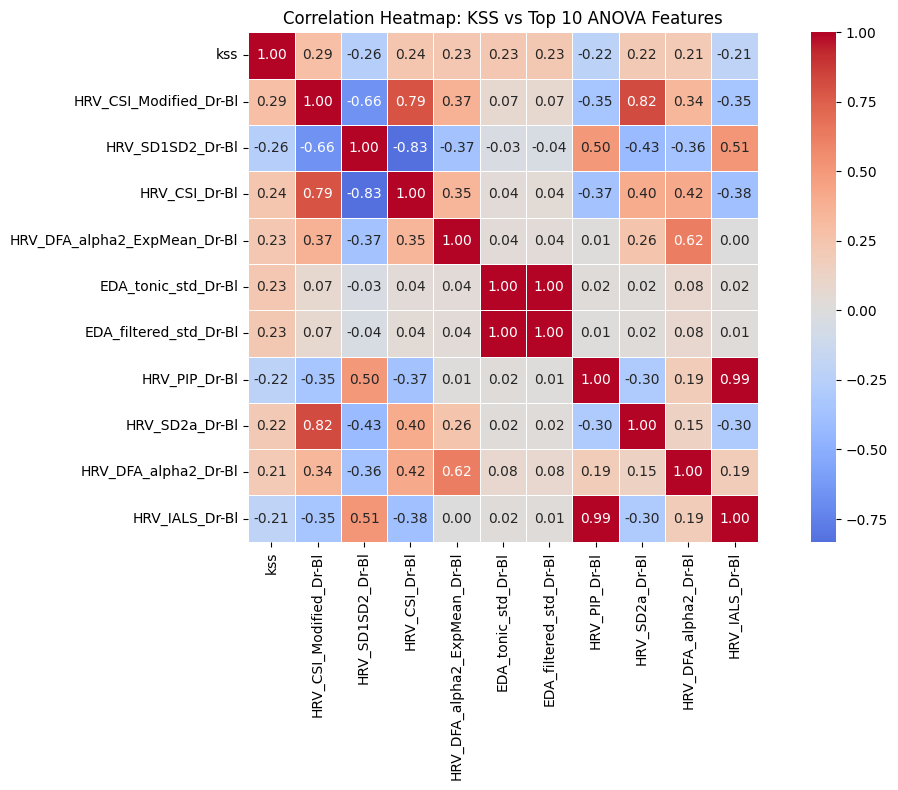


Correlations with KSS:
kss                             1.000000
HRV_CSI_Modified_Dr-Bl          0.290599
HRV_CSI_Dr-Bl                   0.235224
HRV_DFA_alpha2_ExpMean_Dr-Bl    0.230632
EDA_tonic_std_Dr-Bl             0.229492
EDA_filtered_std_Dr-Bl          0.226308
HRV_SD2a_Dr-Bl                  0.217573
HRV_DFA_alpha2_Dr-Bl            0.208457
HRV_IALS_Dr-Bl                 -0.206523
HRV_PIP_Dr-Bl                  -0.220169
HRV_SD1SD2_Dr-Bl               -0.262478
Name: kss, dtype: float64


In [ ]:
# Create correlation heatmap for RT and top 10 ANOVA features
import seaborn as sns
import matplotlib.pyplot as plt

# Select features for correlation analysis
anova_top_10_features = anova_df.head(10)['feature'].tolist()
features_for_corr = ['kss'] + anova_top_10_features

# Calculate correlation matrix
correlation_matrix = final_df[features_for_corr].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make cells square
            linewidths=0.5)  # Add lines between cells

plt.title('Correlation Heatmap: KSS vs Top 10 ANOVA Features')
plt.tight_layout()
plt.show()

# Print the actual correlation values with KSS
print("\nCorrelations with KSS:")
kss_correlations = correlation_matrix['kss'].sort_values(ascending=False)
print(kss_correlations)

In [ ]:
final_df.head()

,subject_id,segment,kss,EDA_filtered_mean_Dr-Bl,EDA_filtered_min_Dr-Bl,EDA_filtered_max_Dr-Bl,EDA_filtered_std_Dr-Bl,EDA_tonic_mean_Dr-Bl,EDA_tonic_min_Dr-Bl,EDA_tonic_max_Dr-Bl,...,RSA_P2T_Mean_Dr-Bl,RSA_P2T_Mean_log_Dr-Bl,RSA_P2T_SD_Dr-Bl,RSA_P2T_NoRSA_Dr-Bl,RSA_PorgesBohrer_Dr-Bl,RSA_Gates_Mean_Dr-Bl,RSA_Gates_Mean_log_Dr-Bl,RSA_Gates_SD_Dr-Bl,first_scenario_rural,period_rural
0,1,0,4.00,0.192599,0.106246,0.303119,0.311051,0.190831,0.090749,0.331519,...,-0.439029,-0.612253,-0.253289,0.0,0.706020,-1.706342,-1.723881,-0.101515,1,1
1,1,1,3.75,-0.062778,-0.124291,0.029813,0.211281,-0.065428,-0.135744,0.051037,...,-0.449185,-0.633101,-0.332933,0.0,0.291752,-1.357260,-1.366498,-0.038428,1,1
2,1,2,3.50,-0.013013,-0.057328,0.186555,0.249670,-0.015501,-0.068399,0.160288,...,-0.323836,-0.386218,0.085438,0.0,0.526990,-1.353469,-1.362631,-0.047260,1,1
3,1,3,3.25,-0.163920,-0.183675,-0.054748,0.113966,-0.167572,-0.196463,-0.048600,...,-0.389347,-0.512480,0.034591,0.0,0.276519,-1.045954,-1.050055,-0.004415,1,1
4,1,4,3.00,-0.272893,-0.307925,-0.106054,0.088176,-0.276388,-0.320220,-0.107909,...,-0.334330,-0.406057,-0.030445,0.0,0.355233,-1.150875,-1.156470,-0.048994,1,1


### Plot

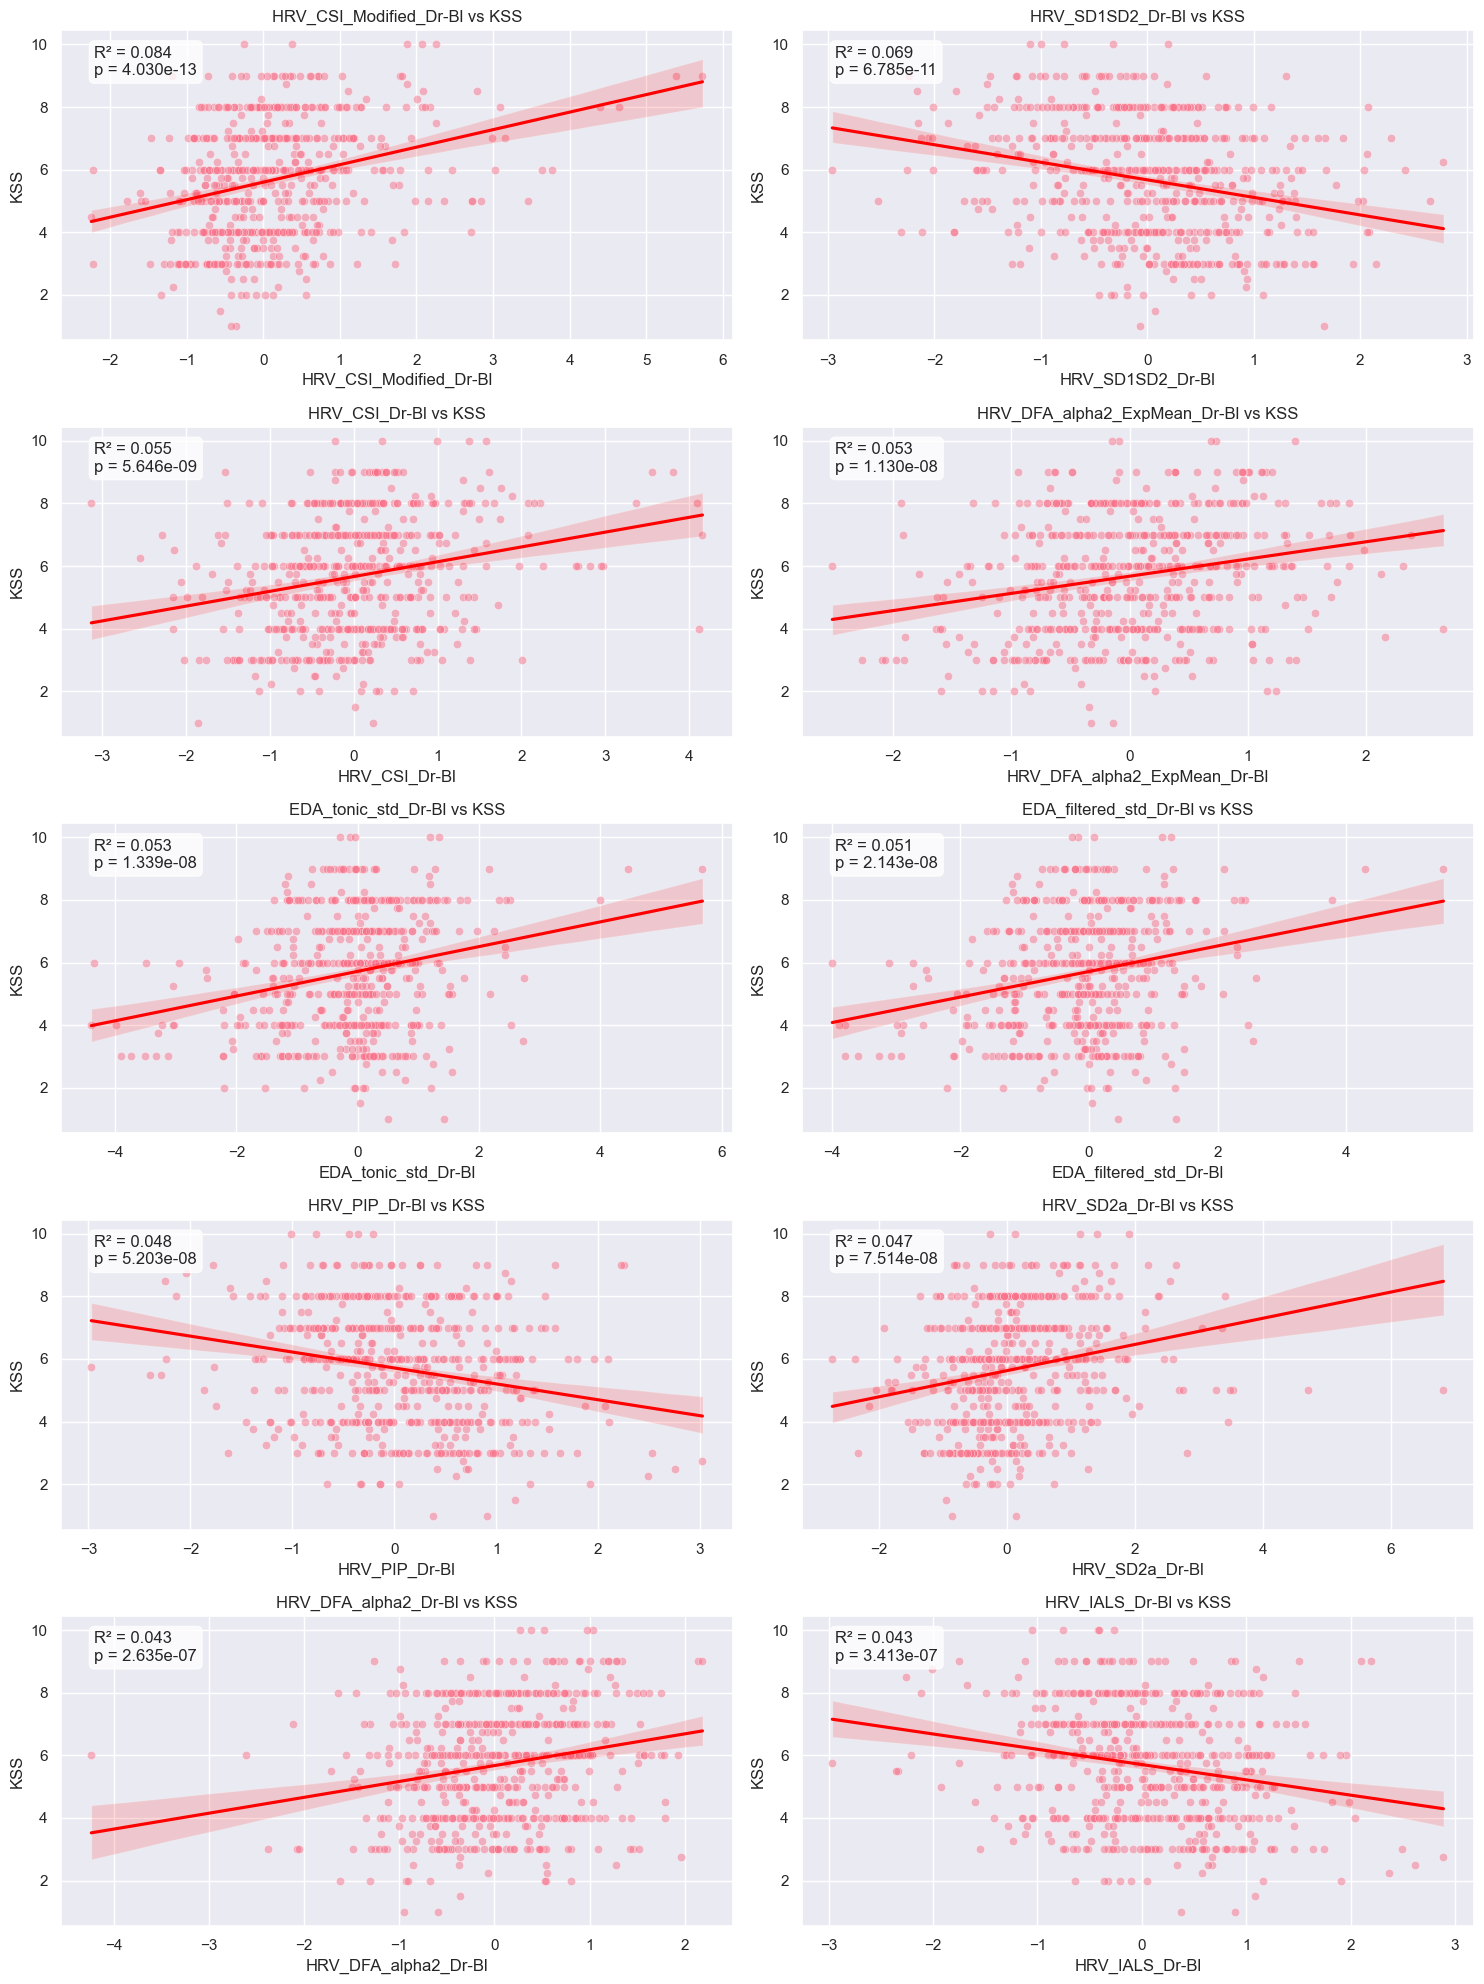


Correlation Statistics:
--------------------------------------------------
HRV_CSI_Modified_Dr-Bl:
  Pearson correlation: 0.291
  p-value: 4.030e-13
--------------------------------------------------
HRV_SD1SD2_Dr-Bl:
  Pearson correlation: -0.262
  p-value: 6.785e-11
--------------------------------------------------
HRV_CSI_Dr-Bl:
  Pearson correlation: 0.235
  p-value: 5.646e-09
--------------------------------------------------
HRV_DFA_alpha2_ExpMean_Dr-Bl:
  Pearson correlation: 0.231
  p-value: 1.130e-08
--------------------------------------------------
EDA_tonic_std_Dr-Bl:
  Pearson correlation: 0.229
  p-value: 1.339e-08
--------------------------------------------------
EDA_filtered_std_Dr-Bl:
  Pearson correlation: 0.226
  p-value: 2.143e-08
--------------------------------------------------
HRV_PIP_Dr-Bl:
  Pearson correlation: -0.220
  p-value: 5.203e-08
--------------------------------------------------
HRV_SD2a_Dr-Bl:
  Pearson correlation: 0.218
  p-value: 7.514e-08
--

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up the plotting style
sns.set_theme()  # Use seaborn's default theme
sns.set_palette("husl")

# Create subplots for each feature
n_features = len(anova_top_10_features)
n_cols = 2
n_rows = (n_features + 1) // 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

# Plot each feature against KSS
for idx, feature in enumerate(anova_top_10_features):
    ax = axes[idx]
    
    # Create scatter plot
    sns.scatterplot(data=final_df, x=feature, y='kss', alpha=0.5, ax=ax)
    
    # Add regression line with confidence interval
    sns.regplot(data=final_df, x=feature, y='kss', 
                scatter=False, color='red', ax=ax)
    
    # Calculate correlation statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(final_df[feature], final_df['kss'])
    
    # Add correlation info to plot
    ax.text(0.05, 0.95, 
            f'R² = {r_value**2:.3f}\np = {p_value:.3e}',
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Customize plot
    ax.set_title(f'{feature} vs KSS')
    ax.set_xlabel(feature)
    ax.set_ylabel('KSS')

# Remove any empty subplots
for idx in range(len(anova_top_10_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Print correlation statistics
print("\nCorrelation Statistics:")
print("-" * 50)
for feature in anova_top_10_features:
    correlation = stats.pearsonr(final_df[feature], final_df['kss'])
    print(f"{feature}:")
    print(f"  Pearson correlation: {correlation[0]:.3f}")
    print(f"  p-value: {correlation[1]:.3e}")
    print("-" * 50)

### PCA

In [ ]:
final_df.head()

,subject_id,segment,kss,EDA_filtered_mean_Dr-Bl,EDA_filtered_min_Dr-Bl,EDA_filtered_max_Dr-Bl,EDA_filtered_std_Dr-Bl,EDA_tonic_mean_Dr-Bl,EDA_tonic_min_Dr-Bl,EDA_tonic_max_Dr-Bl,...,RSA_P2T_Mean_Dr-Bl,RSA_P2T_Mean_log_Dr-Bl,RSA_P2T_SD_Dr-Bl,RSA_P2T_NoRSA_Dr-Bl,RSA_PorgesBohrer_Dr-Bl,RSA_Gates_Mean_Dr-Bl,RSA_Gates_Mean_log_Dr-Bl,RSA_Gates_SD_Dr-Bl,first_scenario_rural,period_rural
0,1,0,4.00,0.192599,0.106246,0.303119,0.311051,0.190831,0.090749,0.331519,...,-0.439029,-0.612253,-0.253289,0.0,0.706020,-1.706342,-1.723881,-0.101515,1,1
1,1,1,3.75,-0.062778,-0.124291,0.029813,0.211281,-0.065428,-0.135744,0.051037,...,-0.449185,-0.633101,-0.332933,0.0,0.291752,-1.357260,-1.366498,-0.038428,1,1
2,1,2,3.50,-0.013013,-0.057328,0.186555,0.249670,-0.015501,-0.068399,0.160288,...,-0.323836,-0.386218,0.085438,0.0,0.526990,-1.353469,-1.362631,-0.047260,1,1
3,1,3,3.25,-0.163920,-0.183675,-0.054748,0.113966,-0.167572,-0.196463,-0.048600,...,-0.389347,-0.512480,0.034591,0.0,0.276519,-1.045954,-1.050055,-0.004415,1,1
4,1,4,3.00,-0.272893,-0.307925,-0.106054,0.088176,-0.276388,-0.320220,-0.107909,...,-0.334330,-0.406057,-0.030445,0.0,0.355233,-1.150875,-1.156470,-0.048994,1,1


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

print("=== Principal Component Analysis ===")

# 1. Prepare features for PCA
# Identify different column types
metadata_cols = ['subject_id', 'first_scenario', 'period', 'segment', 'rf']
categorical_cols = ['first_scenario_rural', 'period_rural']
feature_cols = [col for col in final_df.columns if col not in metadata_cols + categorical_cols]

print("\nNumber of features for PCA:", len(feature_cols))
print("Features:", feature_cols)

# 2. Apply PCA directly on scaled features
# Note: Data was already scaled using RobustScaler during cleaning
X = final_df[feature_cols].values
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X)

# Print PCA results
print(f"\nNumber of components selected: {pca.n_components_}")
print("\nVariance explained by each component:")
var_explained = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(pca.n_components_)],
    'Individual Variance (%)': pca.explained_variance_ratio_ * 100,
    'Cumulative Variance (%)': np.cumsum(pca.explained_variance_ratio_) * 100
})
print(var_explained.round(2))

# Create column names for PCA components
pca_cols = [f'PC{i+1}' for i in range(pca.n_components_)]

# Add PCA components to the original dataframe
final_df_pca = final_df.copy()
for i, col in enumerate(pca_cols):
    final_df_pca[col] = X_pca[:, i]

# Print feature loadings
print("\nTop feature loadings for first 3 principal components:")
loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=pca_cols,
    index=feature_cols
)

# For each component, show top 5 features with highest absolute loadings
for component in pca_cols[:10]:
    print(f"\n{component} - Top 5 features:")
    top_features = loadings_df[component].abs().sort_values(ascending=False).head(5)
    for feat, loading in top_features.items():
        print(f"{feat}: {loadings_df.loc[feat, component]:.3f}")


=== Principal Component Analysis ===

Number of features for PCA: 119
Features: ['kss', 'EDA_filtered_mean_Dr-Bl', 'EDA_filtered_min_Dr-Bl', 'EDA_filtered_max_Dr-Bl', 'EDA_filtered_std_Dr-Bl', 'EDA_tonic_mean_Dr-Bl', 'EDA_tonic_min_Dr-Bl', 'EDA_tonic_max_Dr-Bl', 'EDA_tonic_std_Dr-Bl', 'SCR_Peaks_freq_Dr-Bl', 'ECG_Rate_Mean_Dr-Bl', 'HRV_MeanNN_Dr-Bl', 'HRV_SDNN_Dr-Bl', 'HRV_SDANN1_Dr-Bl', 'HRV_SDNNI1_Dr-Bl', 'HRV_RMSSD_Dr-Bl', 'HRV_SDSD_Dr-Bl', 'HRV_CVNN_Dr-Bl', 'HRV_CVSD_Dr-Bl', 'HRV_MedianNN_Dr-Bl', 'HRV_MadNN_Dr-Bl', 'HRV_MCVNN_Dr-Bl', 'HRV_IQRNN_Dr-Bl', 'HRV_pNN50_Dr-Bl', 'HRV_pNN20_Dr-Bl', 'HRV_HTI_Dr-Bl', 'HRV_TINN_Dr-Bl', 'HRV_LF_Dr-Bl', 'HRV_HF_Dr-Bl', 'HRV_VHF_Dr-Bl', 'HRV_LFHF_Dr-Bl', 'HRV_LFn_Dr-Bl', 'HRV_HFn_Dr-Bl', 'HRV_LnHF_Dr-Bl', 'HRV_SD1_Dr-Bl', 'HRV_SD2_Dr-Bl', 'HRV_SD1SD2_Dr-Bl', 'HRV_S_Dr-Bl', 'HRV_CSI_Dr-Bl', 'HRV_CVI_Dr-Bl', 'HRV_CSI_Modified_Dr-Bl', 'HRV_PIP_Dr-Bl', 'HRV_IALS_Dr-Bl', 'HRV_PSS_Dr-Bl', 'HRV_PAS_Dr-Bl', 'HRV_GI_Dr-Bl', 'HRV_SI_Dr-Bl', 'HRV_AI_Dr-Bl',

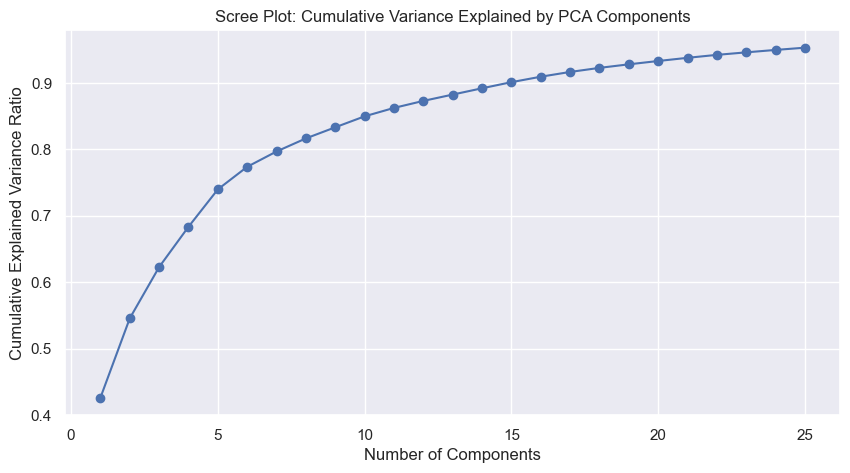

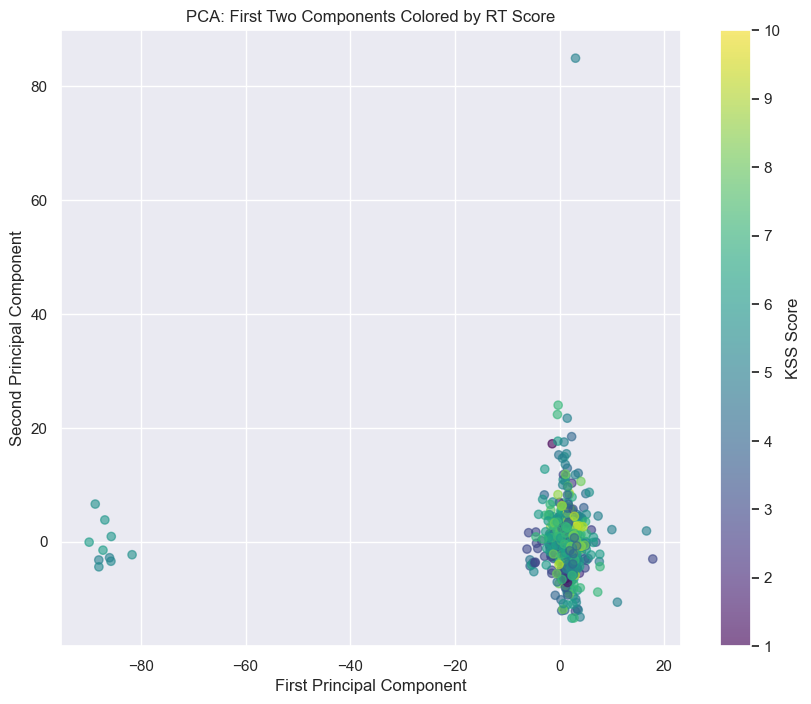


Correlations between Principal Components and KSS:
      PC  Correlation_with_KSS
11  PC12                 0.504
8    PC9                -0.382
10  PC11                 0.300
5    PC6                -0.296
13  PC14                 0.283
18  PC19                 0.254
12  PC13                 0.252
7    PC8                 0.245
6    PC7                -0.201
3    PC4                -0.166
20  PC21                -0.125
16  PC17                -0.118
21  PC22                 0.113
19  PC20                 0.103
4    PC5                -0.093
1    PC2                 0.079
22  PC23                 0.058
15  PC16                -0.052
2    PC3                 0.031
17  PC18                 0.031
0    PC1                 0.029
9   PC10                -0.026
23  PC24                -0.025
14  PC15                 0.014
24  PC25                 0.005


In [ ]:
# Visualize PCA results
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 
         'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot: Cumulative Variance Explained by PCA Components')
plt.grid(True)
plt.show()

# 2. Scatter plot of first two PCs colored by KSS
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=final_df['kss'], 
                     cmap='viridis', 
                     alpha=0.6)
plt.colorbar(scatter, label='KSS Score')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First Two Components Colored by RT Score')
plt.grid(True)
plt.show()

# 3. Correlation between PCs and KSS
pc_kss_corr = pd.DataFrame()
pc_kss_corr['PC'] = pca_cols
pc_kss_corr['Correlation_with_KSS'] = [final_df_pca[col].corr(final_df_pca['kss']) for col in pca_cols]
pc_kss_corr = pc_kss_corr.sort_values('Correlation_with_KSS', key=abs, ascending=False)

print("\nCorrelations between Principal Components and KSS:")
print(pc_kss_corr.round(3))
